# **1. Connecting to Google Drive**


In [ ]:
# Importing the necessary module to mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')
# Changing the current directory to the specified path on Google Drive
%cd "/content/drive/My Drive/emnist"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/emnist


# **2. Importing libraries**

In [ ]:
# Installing the Keras Tuner library using pip
!pip install keras-tuner

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, RMSprop
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras.layers import Activation
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy
import keras_tuner as kt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

# **3. Understanding the dataset**

## 3.1. Reading the data

In [ ]:
# Loading the training dataset from a CSV file into a pandas DataFrame
train = pd.read_csv("emnist-balanced-train.csv", header=None)

# Loading the testing dataset from a CSV file into a pandas DataFrame
test = pd.read_csv("emnist-balanced-test.csv", header=None)

# Loading the mapping information from a text file into a pandas DataFrame,
# where each row represents a mapping between a class label and its corresponding character
mapping = pd.read_csv("emnist-balanced-mapping.txt", sep=" ", header=None)


## 3.2. Checking the size

In [ ]:
print("train size:", train.shape)
print("test size:", test.shape)

train size: (112800, 785)
test size: (18800, 785)


## 3.3. Running one of the datasets to get a feel of what we're working with

In [ ]:
train

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112795,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112796,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112798,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.4. Visualising the dataset

### 3.4.1. What the images in the dataset look like without any preprocessing:

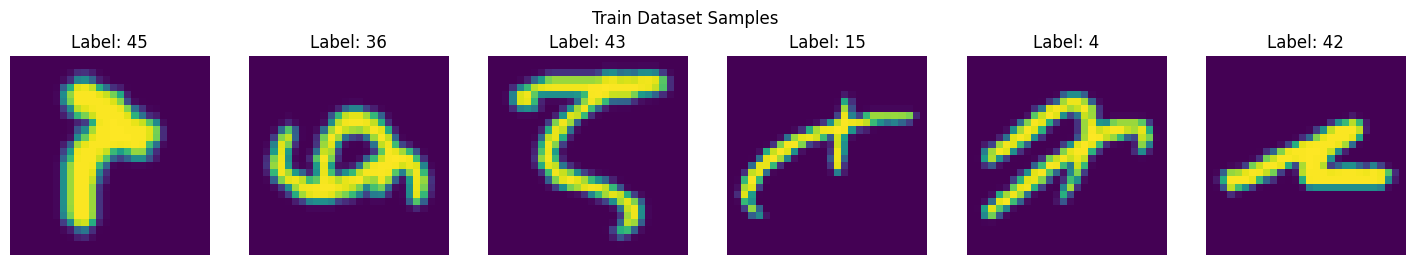

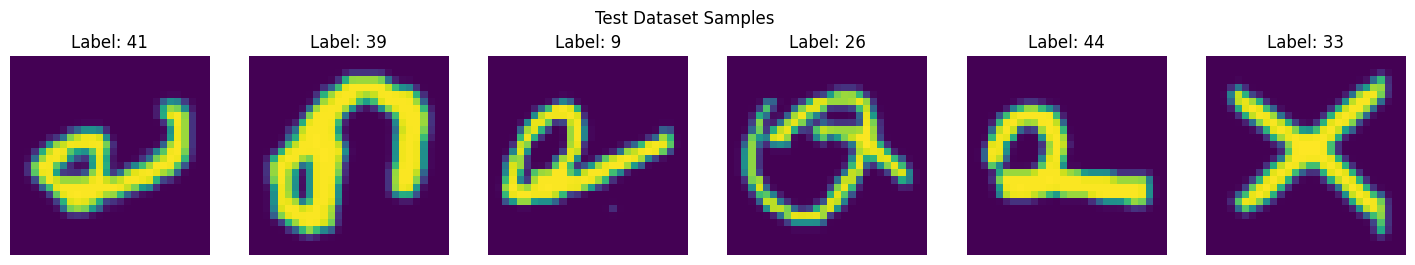

In [ ]:
# Function to display images from the dataset
# Parameters:
#   - dataset: pandas DataFrame containing image data
#   - title: title for the plot
def display_images(dataset, title):

    plt.figure(figsize=(18, 3))
    num_images = len(dataset)

    # Looping through each image in the dataset
    for i in range(num_images):

        plt.subplot(1, num_images, i + 1)
        # Extracting the image data and reshaping it into a 28x28 array
        # the reshaping is necessary to convert the flattened image data
        # into a format that can be correctly displayed and interpreted as images
        image = dataset.iloc[i][1:].values.reshape((28, 28))
        plt.imshow(image)
        # Adding a title to the subplot indicating the label of the image
        plt.title(f'Label: {dataset.iloc[i][0]}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Displaying the first 6 samples from the train dataset in the same row
display_images(train.head(6), title='Train Dataset Samples')

# Displaying the first 6 samples from the test dataset in the same row
display_images(test.head(6), title='Test Dataset Samples')

### 3.4.2. Preparing the images for use:



3.4.2.1.Creating a list of the ascii values in the map.txt file given

In [ ]:
ascii_map = []
for i in mapping.values:
    ascii_map.append(i[1])

3.4.2.2. Rotating and flipping the images to make them more understandable

As seen previously, the images aren't very understandable so it is necessary to rotate and flip them. While training can be done without this, it is mostly done for human convenience; it might sometimes improve model performance as well if done randomly to make the model better able to handle variations in the test data.

In [ ]:
# Function to process an image
# Parameters:
#   - image: NumPy array representing the image data
# Returns:
#   - Processed image as a NumPy array
def imgProcess(image):
    # Reshaping the image into a 28x28 array
    image = image.reshape([28, 28])
    # Rotating the image 90 degrees clockwise and flipping it left to right
    image = np.rot90(np.fliplr(image))
    return image

3.4.2.3. Converting labels to one-hot encoding and reshaping image features into the appropriate format


In [ ]:
# Function to preprocess a dataset
# Parameters:
#   - dataset: pandas DataFrame containing image data and labels
# Returns:
#   - Preprocessed features (images) and labels
def preprocess_dataset(dataset):
    # Define the number of classes
    num_classes = len(ascii_map)

    # Extract labels and convert to one-hot encoding
    # this is done to put the class labels in a format suitable for machine learning models
    labels = dataset.iloc[:, 0].astype('float32')
    y_dataset = tf.keras.utils.to_categorical(labels, num_classes)

    # Extract features from the dataset and reshape images using imgProcess function defined previously
    features = dataset.iloc[:, 1:].values.astype('float32')
    x_dataset = np.array([imgProcess(image) for image in features])
    # reshapes the input image data into a 4D array with dimensions representing the number of samples,
    # height, width, and channels, conforming to the format expected by NNs
    x_dataset = x_dataset.reshape(x_dataset.shape[0], 28, 28, 1)

    return x_dataset, y_dataset


# Preprocess the train dataset
x_train, y_train = preprocess_dataset(train)
# Preprocess the test dataset
x_test, y_test = preprocess_dataset(test)

3.4.2.4. Plotting the result of these changes

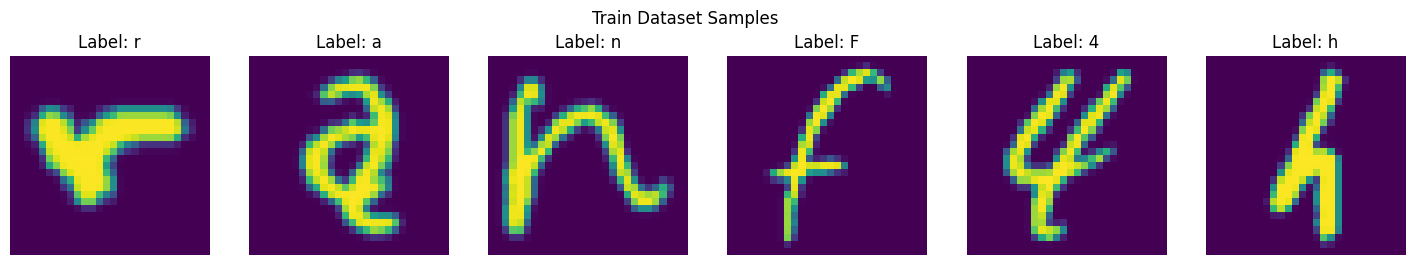

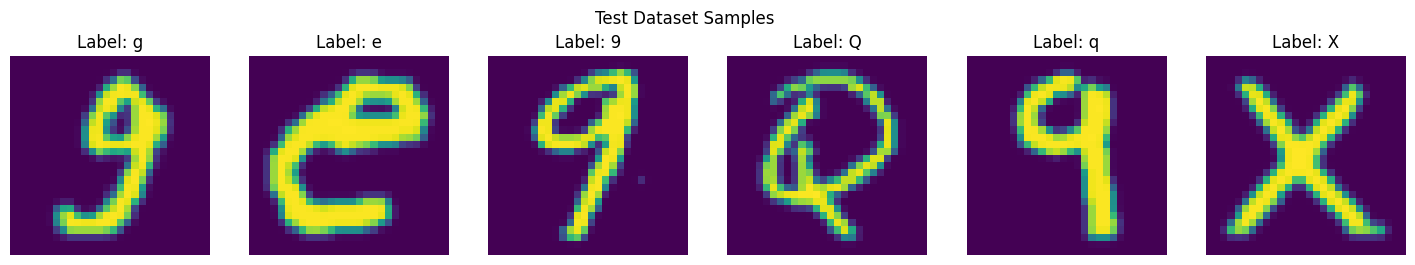

In [ ]:
# Function to display images from a dataset with their corresponding labels
# Parameters:
#   - dataset: NumPy array containing image data
#   - title: title for the plot
#   - y_labels: one-hot encoded labels corresponding to the images
def display_images(dataset, title, y_labels):

    plt.figure(figsize=(18, 3))
    num_images = len(dataset)

    # Looping through each image in the dataset
    for i in range(num_images):

        plt.subplot(1, num_images, i + 1)
        image = dataset[i]
        plt.imshow(image)
        # Getting the index of the one-hot encoded label
        label_index = np.argmax(y_labels[i])
        # Getting the corresponding character label from the ASCII mapping
        plt.title(f'Label: {chr(int(ascii_map[label_index]))}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Display the previous 6 sampled from the train dataset in the same row
display_images(x_train[:6], title='Train Dataset Samples', y_labels=y_train)

# Display the previous 6 sampled from the test dataset in the same row
display_images(x_test[:6], title='Test Dataset Samples', y_labels=y_test)

# **4. CNN**

## 4.1. Baseline CNN model
This model is made using previous knowledge of CNNs, and will then be optimized to increase performance

### 4.1.1. Defining and compiling the base model

In [ ]:
# Define the architecture of the baseline model
# Parameters:
#   - input_shape: shape of the input images
#   - num_classes: number of classes (characters) in the dataset
# Returns:
#   - Keras Sequential model representing the baseline model architecture
def baseline_model(input_shape, num_classes):

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Example input shape for EMNIST dataset
input_shape = (28, 28, 1)
num_classes = len(ascii_map)
# Initialize the baseline model using the defined architecture
baseline_model = baseline_model(input_shape, num_classes)

# Compile baseline model
baseline_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

### 4.1.2. Splitting the training data 80:20 for the training and validation purposes

In [ ]:
# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### 4.1.3. Training and evaluating the baseline model

In [ ]:
# Train the baseline model on the training dataset
# - x_train: input features of the training dataset
# - y_train: corresponding target labels of the training dataset
# - epochs: number of epochs (iterations over the entire dataset) for training
# - batch_size: number of samples per gradient update during training
# - validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch
history_baseline = baseline_model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

# Evaluate the trained baseline model on the test set
# - x_test: input features of the test dataset
# - y_test: corresponding target labels of the test dataset
test_loss, test_accuracy = baseline_model.evaluate(x_test, y_test)

print(f'Test loss (baseline): {test_loss}, Test accuracy (baseline): {test_accuracy}')

Epoch 1/10
361/361 [==============================] - 41s 110ms/step - loss: 2.1330 - accuracy: 0.6485 - val_loss: 0.6334 - val_accuracy: 0.7997
Epoch 2/10
361/361 [==============================] - 40s 110ms/step - loss: 0.5410 - accuracy: 0.8243 - val_loss: 0.5716 - val_accuracy: 0.8146
Epoch 3/10
361/361 [==============================] - 40s 112ms/step - loss: 0.4204 - accuracy: 0.8564 - val_loss: 0.5165 - val_accuracy: 0.8289
Epoch 4/10
361/361 [==============================] - 40s 112ms/step - loss: 0.3476 - accuracy: 0.8796 - val_loss: 0.4985 - val_accuracy: 0.8394
Epoch 5/10
361/361 [==============================] - 42s 116ms/step - loss: 0.2990 - accuracy: 0.8923 - val_loss: 0.4951 - val_accuracy: 0.8405
Epoch 6/10
361/361 [==============================] - 41s 114ms/step - loss: 0.2601 - accuracy: 0.9045 - val_loss: 0.5300 - val_accuracy: 0.8445
Epoch 7/10
361/361 [==============================] - 38s 105ms/step - loss: 0.2233 - accuracy: 0.9166 - val_loss: 0.5616 - val_ac

4.1.3.1. Creating a summary of the baseline model

In [ ]:
baseline_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 1600)              0         
                                                                 
 dense_16 (Dense)            (None, 128)              

4.1.3.2. Plotting the Loss and Accuracy graph for the baseline model

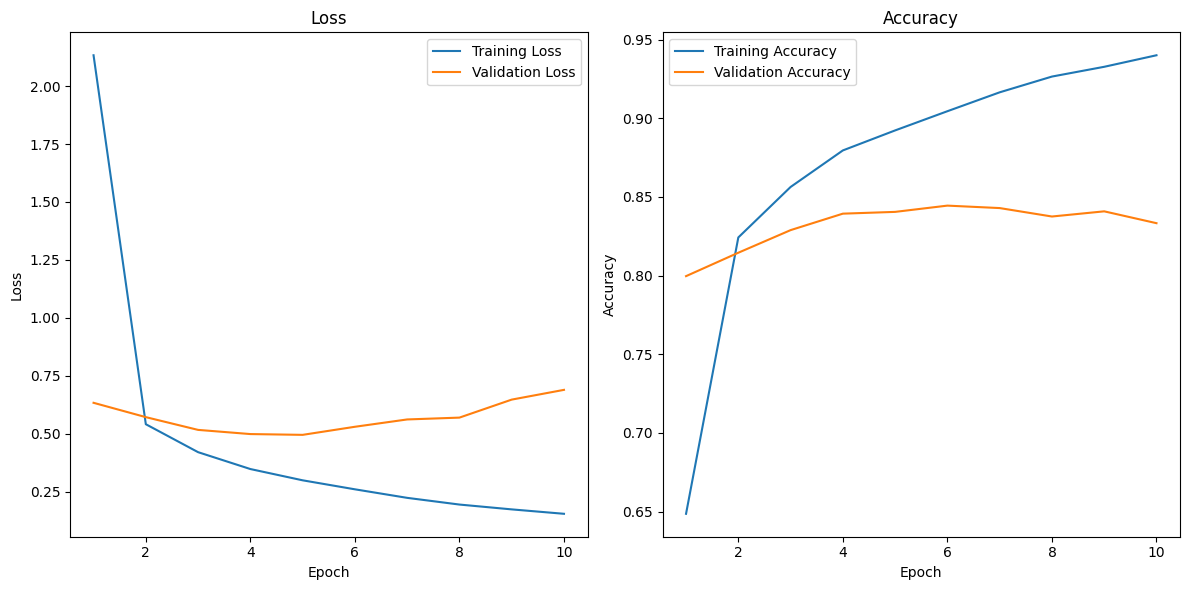

In [ ]:
# Get the training loss and accuracy values from the history object
train_loss = history_baseline.history['loss']
train_accuracy = history_baseline.history['accuracy']

# Get the validation loss and accuracy values from the history object
val_loss = history_baseline.history['val_loss']
val_accuracy = history_baseline.history['val_accuracy']

# Create a figure and axis objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot training and validation loss
ax[0].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
ax[0].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
ax[1].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

Based on the Accuracy graph, we can see that the baseline model is overfitting to the training data.

## 4.2. Hyperparameter Tuning

### 4.2.1. Neural Network Model Definition and Initialization

In [ ]:
class NN:
    """
    This class represents a neural network for image classification tasks.
    It provides methods for defining a convolutional neural network (CNN) model
    and building a CNN model with hyperparameters for hyperparameter tuning.

    Attributes:
        x_train: NumPy array containing input features of the training dataset.
        y_train: NumPy array containing corresponding target labels of the training dataset.
    """
    # Constructor initializing the class with training data.
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    # Method to define a convolutional neural network (CNN) model.
    # Three drop layers were added to this to solve the problem with overfitting, based on the tuning
    # Parameters:
    #   - activation: Activation function for the hidden layers.
    #   - optimizer: Optimization algorithm.
    #   - regularizer: Regularization technique for controlling overfitting.
    #   - drop: Dropout rate for regularization.
    #   - num_classes: Number of classes for classification.
    # Returns:
    #   - Keras Sequential model representing the CNN architecture.
    def cnn(self, activation, optimizer, regularizer, drop, num_classes):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=(28, 28, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(drop))
        model.add(Conv2D(64, kernel_size=(3, 3), activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(drop))
        model.add(Flatten())
        model.add(Dense(128, activation=activation, kernel_regularizer=regularizer))
        model.add(Dropout(drop))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    # Method to build a CNN model with hyperparameters for hyperparameter tuning.
    # Parameters:
    #   - hp: Hyperparameters object for specifying search space.
    # Returns:
    #   - Keras Sequential model representing the CNN architecture with hyperparameters.
    def build_cnn(self, hp):
        hp_activation = hp.Choice('activation_function', values=['relu', 'tanh', 'elu'])
        hp_adaptive = hp.Choice('learning_rate_scheduler', values = ['time', 'step'])
        hp_optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop', 'adagrad'])
        hp_regularizer = hp.Choice('regularizer', values = ['l1', 'l2', 'l1_l2'])
        hp_drop = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)

        model = self.cnn(activation = hp_activation, optimizer = hp_optimizer, regularizer = hp_regularizer, drop = hp_drop)

        return model

# Defining the number of classes, also could have using the mapping done at the beggining of code
num_classes = y_train.shape[1]

# Initialize the NN instance with the split data
nn = NN(x_train, y_train)

# Defining a custom callback for reducing the learning rate during training
# Its purpose is to help the model converge faster and potentially improve performance by
# reducing the learning rate when the validation loss stops decreasing.
# This can prevent overshooting the minima and improve the model's ability to generalize to unseen data.
# Parameters:
#   - monitor: Quantity to be monitored (in this case, validation loss)
#   - factor: Factor by which the learning rate will be reduced
#   - patience: Number of epochs with no improvement after which learning rate will be reduced
#   - min_lr: Lower bound on the learning rate
#   - verbose: Verbosity mode (0: silent, 1: update messages)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

### 4.2.2. Automatic tuning for hyperparameters

In [ ]:
# Initialize the tuner for hyperparameter optimization
# - hypermodel_cnn: Function that builds the CNN model with hyperparameters for tuning
# - objective: Metric to optimize during hyperparameter search (in this case, validation accuracy)
# - max_epochs: Maximum number of epochs to train each model during hyperparameter search
# - directory: Directory to store the results of the hyperparameter search
# - project_name: Name of the hyperparameter tuning project (which has been different for each run, as
# hyperparameters were chosen through a mix of manual and automatic tuning- changing the project name
# ensured new trials with the selected hyperparameters)
hypermodel_cnn = nn.build_cnn
tuner_cnn = kt.Hyperband(hypermodel_cnn,
                         objective='val_accuracy',
                         max_epochs=20,
                         directory='cnn',
                         project_name='cnn_optimization2')

# Search for the best hyperparameters with callbacks
# - x_train: Input features of the training dataset
# - y_train: Corresponding target labels of the training dataset
# - epochs: Number of epochs to train each model during hyperparameter search
# - validation_data: Data on which to evaluate the model during hyperparameter search
# - callbacks: List of callbacks to apply during training (in this case, reduce learning rate callback)
tuner_cnn.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[reduce_lr])

## 4.3. Building the model with the optimal hyperparameters
The optimal hyperparameters are chosen through a mixture of manual and automatic tuning (refer to report for more details)- the rest of the code uses those optimal parameters and does not show each and every combination that was used to reach this conclusion.
The hyperparameters are: relu, adam, l1 and drop of 0.15.

In [ ]:
# Build the best model using the optimal hyperparameters obtained from hyperparameter tuning
# - activation: Activation function for the hidden layers which was chosen to be relu
# - optimizer: Optimization algorithm which was chosen to be adam
# - regularizer: Regularization technique (l1 chosen)
# - drop: Dropout rate for regularization
# - num_classes: Number of classes for classification
model_cnn = nn.cnn(activation='relu', optimizer='adam', regularizer=l1(0.001),
                   drop=0.15, num_classes=num_classes)

# recording the time before training the CNN model
start_cnn = time.time()
# Fit the best model on the training dataset
# - x_train: Input features of the training dataset
# - y_train: Corresponding target labels of the training dataset
# - epochs: Number of epochs (iterations over the entire dataset) for training
# - batch_size: Number of samples per gradient update during training
# - validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch
history_cnn = model_cnn.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
# recording the time after the training is done
end_cnn = time.time()

print("Training time for CNN model:", end_cnn - start_cnn, "s")

Epoch 1/10
361/361 [==============================] - 40s 106ms/step - loss: 8.6755 - accuracy: 0.1423 - val_loss: 5.0423 - val_accuracy: 0.5123
Epoch 2/10
361/361 [==============================] - 39s 109ms/step - loss: 4.0954 - accuracy: 0.5826 - val_loss: 2.9407 - val_accuracy: 0.7573
Epoch 3/10
361/361 [==============================] - 42s 116ms/step - loss: 2.7099 - accuracy: 0.7093 - val_loss: 2.0653 - val_accuracy: 0.8019
Epoch 4/10
361/361 [==============================] - 39s 109ms/step - loss: 2.0197 - accuracy: 0.7464 - val_loss: 1.5545 - val_accuracy: 0.8184
Epoch 5/10
361/361 [==============================] - 41s 113ms/step - loss: 1.6045 - accuracy: 0.7704 - val_loss: 1.2942 - val_accuracy: 0.8267
Epoch 6/10
361/361 [==============================] - 41s 114ms/step - loss: 1.3450 - accuracy: 0.7810 - val_loss: 1.0847 - val_accuracy: 0.8394
Epoch 7/10
361/361 [==============================] - 39s 108ms/step - loss: 1.1859 - accuracy: 0.7916 - val_loss: 0.9781 - val_ac

### 4.3.1. Creating a summary of the optimized model

In [ ]:
model_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 5, 5, 64)        

### 4.3.2. Testing the optimized(tuned) CNN model on unseen data (in this case the test dataset)

In [ ]:
# Evaluate the optimized CNN model on the test dataset
# - x_test: Input features of the test dataset
# - y_test: Corresponding target labels of the test dataset
test_loss, test_accuracy = model_cnn.evaluate(x_test, y_test)
print(f'Test loss (optimized): {test_loss}, Test accuracy (optimized): {test_accuracy}')

588/588 [==============================] - 5s 9ms/step - loss: 0.8560 - accuracy: 0.8455
Test loss (optimized): 0.855953574180603, Test accuracy (optimized): 0.8455319404602051


## 4.4. Results for optimized CNN

### 4.4.1. Creating the plots for better understanding of the model

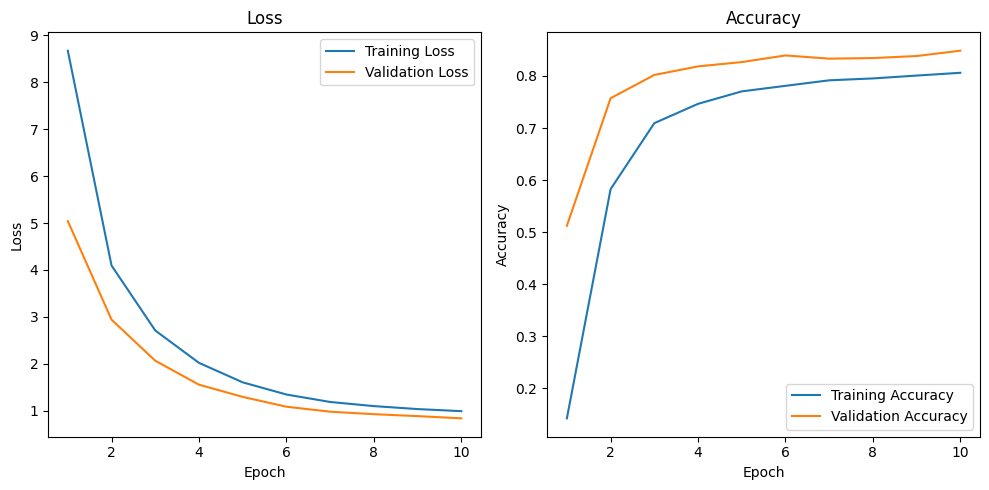

In [ ]:
# Get the training loss and accuracy values from the history object
train_loss = history_cnn.history['loss']
train_accuracy = history_cnn.history['accuracy']

# Get the validation loss and accuracy values from the history object
val_loss = history_cnn.history['val_loss']
val_accuracy = history_cnn.history['val_accuracy']

# Create a figure and axis objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot training and validation loss
ax[0].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
ax[0].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
ax[1].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

# **5. MLP**

## 5.1. Baseline MLP model
This model will then be optimized to increase accuracy

### 5.1.1. Defining and compiling the base model

In [ ]:
# Define baseline model architecture
def baseline_mlp_model(input_shape, num_classes):
    """
    Defines a baseline multi-layer perceptron (MLP) model for classification tasks.
    Parameters:
        input_shape (tuple): The shape of the input img.
        num_classes (int): The number of unique classes in the dataset.
    Returns:
        model (tf.keras.Model): A compiled TensorFlow/Keras model ready for training.
    """
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Example input shape for EMNIST dataset
input_shape=(28,28,1)
num_classes=len(ascii_map)
# Initialize the MLP baseline model using the defined architecture
baseline_mlp_model = baseline_mlp_model(input_shape, num_classes)

# Compile baseline model
baseline_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### 5.1.2. Training and evaluating the baseline model

In [ ]:
# Fit the baseline MLP model on the training data
history_mlp = baseline_mlp_model.fit(x_train, y_train, epochs=10, validation_data=[x_val,y_val], batch_size=128)
# Evaluate the trained baseline MLP model on the test set
test_loss, test_accuracy = baseline_mlp_model.evaluate(x_test, y_test)# Test data used to evaluate the model
print(f'Test loss (baseline): {test_loss}, Test accuracy (baseline): {test_accuracy}')

Epoch 1/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1747 - loss: 10.5271 - val_accuracy: 0.6101 - val_loss: 1.3824
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5562 - loss: 1.5548 - val_accuracy: 0.7047 - val_loss: 0.9508
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6570 - loss: 1.1286 - val_accuracy: 0.7474 - val_loss: 0.8138
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6958 - loss: 0.9722 - val_accuracy: 0.7718 - val_loss: 0.7304
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7271 - loss: 0.8723 - val_accuracy: 0.7814 - val_loss: 0.6968
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7426 - loss: 0.8042 - val_accuracy: 0.7869 - val_loss: 0.6642
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7565 - loss: 0.7605 - val_accuracy: 0.7946 - val_loss: 0.6365
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7663 - loss: 0.7269 - val_accuracy: 0

5.1.3.1. Creating a summary of the baseline model

In [ ]:
baseline_mlp_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,716,623 (6.55 MB)

 Trainable params: 572,207 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,144,416 (4.37 MB)

5.1.3.2. Plotting the Loss and Accuracy graph for the baseline model

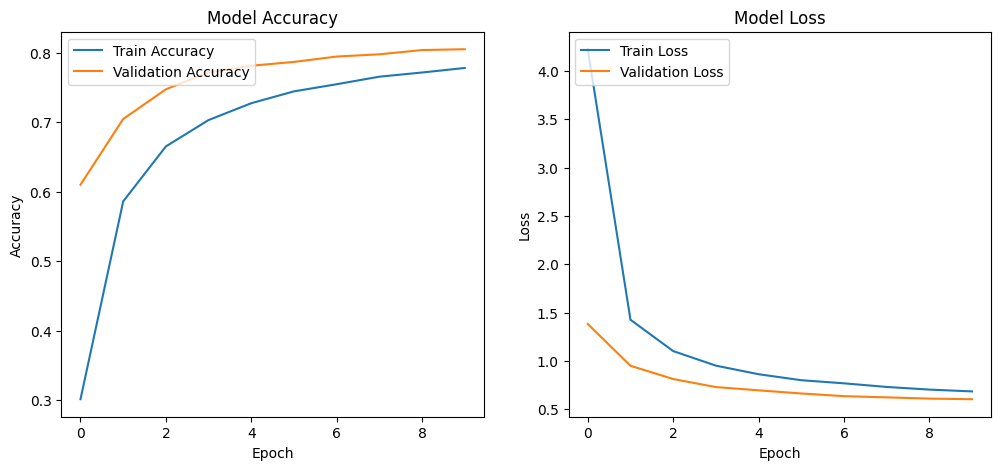

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


As can be seen in the graphs, the baseline model is acceptable but for better result we do the tuning.

## 5.2. Hyperparameter Tuning

### 5.2.1. Exploring all possible combination of hyperparameters to find the best one(in respect to accuracy)

In [ ]:
# Define a function to create an MLP model with configurable hyperparameters
# This let us for easy adjustment of the model's architecture and training configurations
def create_mlp_model(input_shape, num_classes, activation='relu', optimizer='adam', use_bn=False, use_dropout=False, l1_reg=None, l2_reg=None):
    """
    Creates an MLP model with customizable layers and settings.

    Parameters:
    - input_shape (tuple): Shape of the input data
    - num_classes (int): Number of classes for the classification task
    - activation (str): Activation function to use between layers (default 'relu')
    - optimizer (str): Type of optimizer to use (default 'adam')
    - use_bn (bool): Whether to use Batch Normalization after each layer (default False)
    - use_dropout (bool): Whether to use Dropout for regularization (default False)
    - l1_reg (float): L1 regularization factor (default None, which means no L1 regularization)
    - l2_reg (float): L2 regularization factor (default None, which means no L2 regularization)

    Returns:
    - model (Sequential): A compiled Keras model ready for training
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))

    # Add first dense layer with optional L1/L2 regularization
    reg = None
    if l1_reg:
        reg = l1(l1_reg)
    if l2_reg:
        reg = l2(l2_reg)
    model.add(Dense(512, kernel_regularizer=reg))
    if use_bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if use_dropout:
        model.add(Dropout(0.2))

    # Subsequent layers
    for units in [256, 128]:
        model.add(Dense(units, activation=activation, kernel_regularizer=reg))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Activation(activation))
        if use_dropout:
            model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=0.01)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    elif optimizer == 'adamax':
        opt = Adamax(learning_rate=0.002)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Learning rate schedulers that adjust the learning rate during training
def exp_decay(epoch, lr):
    return lr * np.exp(-0.1) if epoch >= 5 else lr

def step_decay(epoch):
    initial_lr = 0.01
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_lr * (drop_rate ** np.floor(epoch / epochs_drop))

# Hyperparameters for test
activations = ['relu', 'elu', 'leaky_relu']
optimizers = ['adam', 'sgd', 'rmsprop', 'adamax']
batch_normalizations = [True, False]
dropouts = [True, False]
regularizations = [(None, None), (0.01, None), (None, 0.01)]

results = []

# Run model training with different configurations and schedulers
for activation in activations:
    for optimizer in optimizers:
        for use_bn in batch_normalizations:
            for use_dropout in dropouts:
                for l1_reg, l2_reg in regularizations:
                    model = create_mlp_model((28, 28, 1), 47, activation, optimizer, use_bn, use_dropout, l1_reg, l2_reg)
                    # Select scheduler based on optimizer choice
                    callback_lr = LearningRateScheduler(exp_decay if optimizer in ['adam', 'adamax'] else step_decay)
                    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128, callbacks=[callback_lr])
                    val_accuracy = max(history.history['val_accuracy'])

                    # Store or print results
                    results.append((activation, optimizer, use_bn, use_dropout, l1_reg, l2_reg, val_accuracy))
                    print(f'Activation: {activation}, Optimizer: {optimizer}, BN: {use_bn}, Dropout: {use_dropout}, L1: {l1_reg}, L2: {l2_reg}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4797 - loss: 2.0012 - val_accuracy: 0.7786 - val_loss: 0.6997 - learning_rate: 0.0010
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7376 - loss: 0.8381 - val_accuracy: 0.8130 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7777 - loss: 0.6878 - val_accuracy: 0.8228 - val_loss: 0.5274 - learning_rate: 0.0010
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7981 - loss: 0.6137 - val_accuracy: 0.8315 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8083 - loss: 0.5721 - val_accuracy: 0.8394 - val_loss: 0.4733 - learning_rate: 0.0010
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8219 - loss: 0.5337 - val_accuracy: 0.8446 - val_loss: 0.4490 - learning_rate: 9.0484e-04
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8276 - loss: 0.499

### 5.2.2 Plot of the information found from tuning process


Top 5 Configurations:
   Activation Optimizer  Batch Normalization  Dropout  L1  L2  \
0        relu      adam                 True     True NaN NaN   
36       relu    adamax                 True     True NaN NaN   
48        elu      adam                 True     True NaN NaN   
72        elu   rmsprop                 True     True NaN NaN   
24       relu   rmsprop                 True     True NaN NaN   

    Validation Accuracy  
0              0.858333  
36             0.856339  
48             0.855585  
72             0.855142  
24             0.854388  


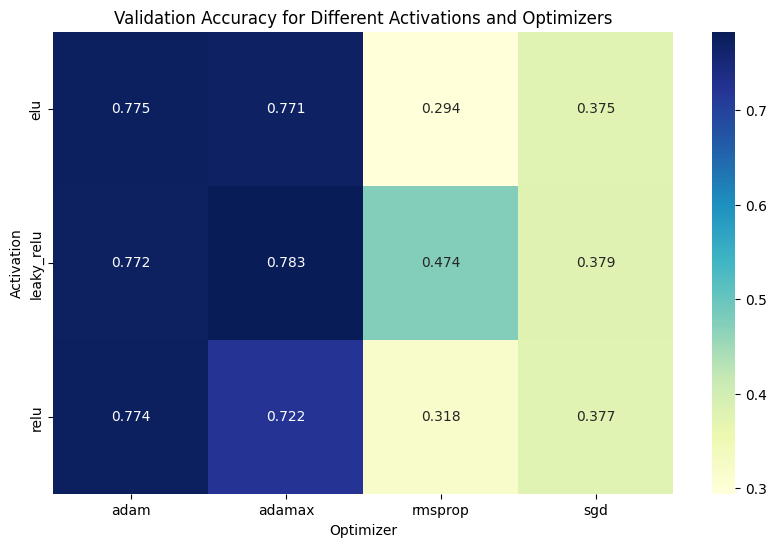

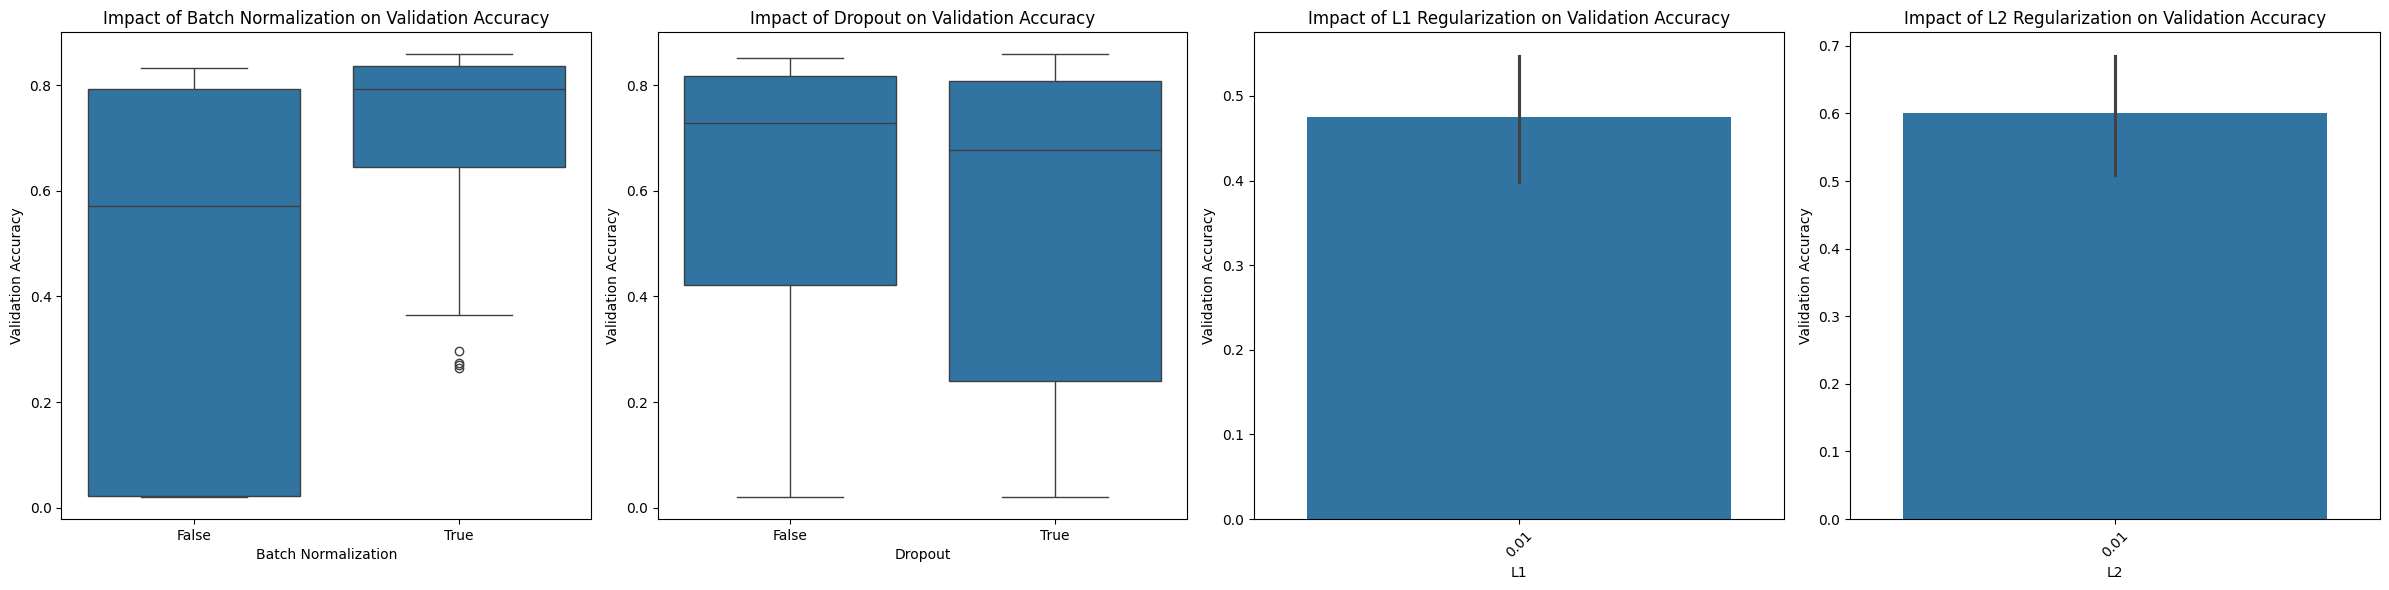

In [ ]:
# Convert results to DataFrame
columns = ['Activation', 'Optimizer', 'Batch Normalization', 'Dropout', 'L1', 'L2', 'Validation Accuracy']
df_results = pd.DataFrame(results, columns=columns)

# Find the top 5 configurations
top_results = df_results.nlargest(5, 'Validation Accuracy')
print("\nTop 5 Configurations:")
print(top_results)

# Heatmap of mean validation accuracy for each activation and optimizer combination
pivot_table = df_results.pivot_table(values='Validation Accuracy', index='Activation', columns='Optimizer', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Validation Accuracy for Different Activations and Optimizers')
plt.show()

# Adjust figure size to show four plots in one row
plt.figure(figsize=(24, 6))

# Plot 1: Impact of Batch Normalization on Validation Accuracy
plt.subplot(1, 4, 1)  # Change from (1, 2, 1) to (1, 4, 1)
sns.boxplot(x='Batch Normalization', y='Validation Accuracy', data=df_results)
plt.title('Impact of Batch Normalization on Validation Accuracy')

# Plot 2: Impact of Dropout on Validation Accuracy
plt.subplot(1, 4, 2)  # Change from (1, 2, 2) to (1, 4, 2)
sns.boxplot(x='Dropout', y='Validation Accuracy', data=df_results)
plt.title('Impact of Dropout on Validation Accuracy')

# Plot 3: Impact of L1 Regularization on Validation Accuracy
plt.subplot(1, 4, 3)  # Change from (1, 2, 1) to (1, 4, 3)
sns.barplot(x='L1', y='Validation Accuracy', data=df_results)
plt.title('Impact of L1 Regularization on Validation Accuracy')
plt.xticks(rotation=45)

# Plot 4: Impact of L2 Regularization on Validation Accuracy
plt.subplot(1, 4, 4)  # Change from (1, 2, 2) to (1, 4, 4)
sns.barplot(x='L2', y='Validation Accuracy', data=df_results)
plt.title('Impact of L2 Regularization on Validation Accuracy')
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## 5.3. Building the model with the optimal hyperparameters


In [ ]:
# Create the best-tuned MLP model using optimal hyperparameters combinations obtained from tuning process
# - activation: Activation function for the hidden layers which was chosen to be relu
# - optimizer: Optimization algorithm which was chosen to be adam
# - regularizer: Regularization technique
# - drop: Dropout rate for regularization
# - num_classes: Number of classes for classification
best_model = create_mlp_model(input_shape=(28, 28, 1), num_classes=len(ascii_map), activation='relu', optimizer='adam', use_bn=True, use_dropout=True)
start_mlp = time.time()
best_model_history = best_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=128)
end_mlp = time.time()

print("Training time for mlp model:", end_mlp - start_mlp, "s")


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4809 - loss: 1.9935 - val_accuracy: 0.7806 - val_loss: 0.6915
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7404 - loss: 0.8412 - val_accuracy: 0.8129 - val_loss: 0.5670
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7768 - loss: 0.6946 - val_accuracy: 0.8262 - val_loss: 0.5121
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7949 - loss: 0.6243 - val_accuracy: 0.8335 - val_loss: 0.4920
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8097 - loss: 0.5655 - val_accuracy: 0.8388 - val_loss: 0.4742
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8198 - loss: 0.5353 - val_accuracy: 0.8432 - val_loss: 0.4536
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8279 - loss: 0.5090 - val_accuracy: 0.8471 - val_loss: 0.4393
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8323 - loss: 0.4853 - val_accuracy: 0.8518 - val_

### 5.3.1. Summary of the optimized(tuned) MLP model

In [ ]:
best_model.summary()

Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_149 (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_596 (Dense)               │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_216         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_432 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_217         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_433 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_218         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_434 (Activation)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_228 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,791 (6.58 MB)

 Trainable params: 573,999 (2.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 1,148,000 (4.38 MB)

### 5.3.2. Testing the optimozed(tuned) MLP model on unseen data (in this case the test dataset)

In [ ]:
# Evaluate the best-tuned MLP model on test datadet
# - x_test: Input features of the test dataset
# - y_test: Corresponding target labels of the test dataset
best_loss, best_accuracy = best_model.evaluate(x_test, y_test)
print(f'Test loss (optimized): {best_loss}, Test accuracy (optimized): {best_accuracy}')

  1/588 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8750 - loss: 0.4767

588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.8528 - loss: 0.4378
Test loss (optimized): 0.43766576051712036, Test accuracy (optimized): 0.8512765765190125


## 5.4. Results for optimized MLP

### 5.4.1. Plots for better understanding the model

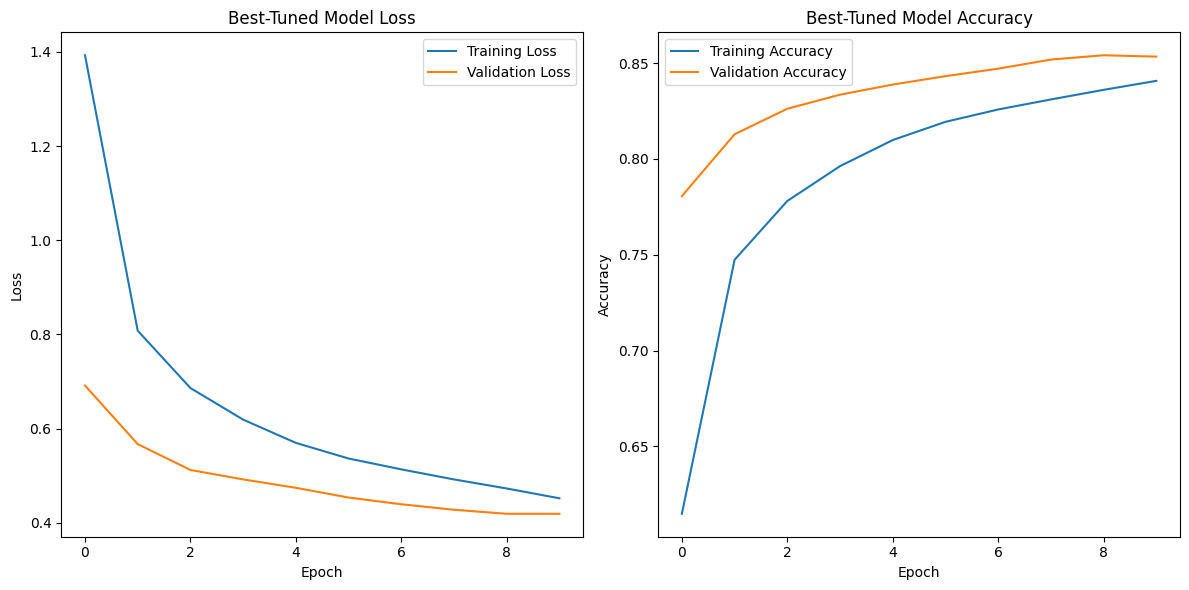

In [ ]:
import matplotlib.pyplot as plt

# Plotting Loss for the Best-Tuned Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_model_history.history['loss'], label='Training Loss')
plt.plot(best_model_history.history['val_loss'], label='Validation Loss')
plt.title('Best-Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy for the Best-Tuned Model
plt.subplot(1, 2, 2)
plt.plot(best_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best-Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## 6. Comparing the performance of CNN and MLP

## 6.1 Predicted and true labels

###  6.1.1. Predicted and true labels(CNN)

1/1 [==============================] - 0s 167ms/step


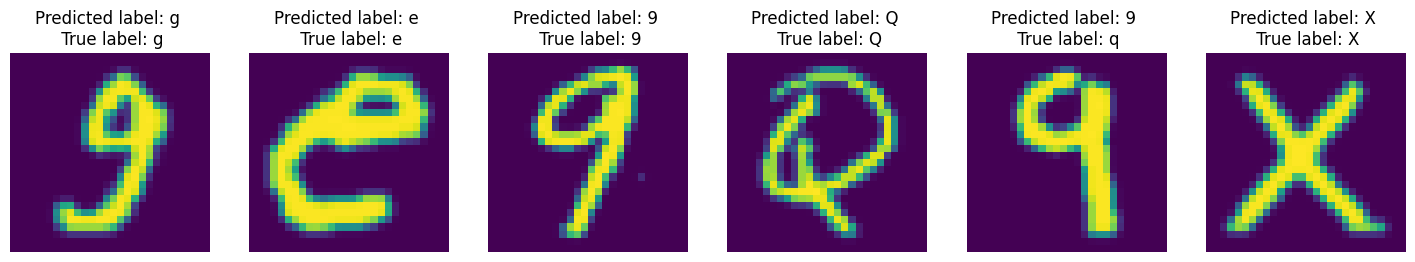

In [ ]:
# Function to display images from a dataset with their corresponding true and predicted labels
# Parameters:
#   - dataset: NumPy array containing image data
#   - title: Title for the plot
#   - y_true_labels: One-hot encoded true labels corresponding to the images
#   - model: Trained model used for making predictions
def display_images_with_predictions(dataset, title, y_true_labels, model):
    plt.figure(figsize=(18, 3))
    num_images = len(dataset)

    # Make predictions on the dataset using the model that is given to the function
    predictions = model.predict(dataset)

    # Loop through each image in the dataset
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = dataset[i]
        plt.imshow(image)

        # Get the index of the predicted labels for the dataset using the provided model
        predicted_label_index = np.argmax(predictions[i])
        # Get the corresponding ASCII character label from the mapping list previously defined
        predicted_label = chr(int(ascii_map[predicted_label_index]))

        # Get the index of the true label from the one-hot encoded format
        true_label_index = np.argmax(y_true_labels[i])
        # Get the corresponding ASCII character true label from the mapping
        true_label = chr(int(ascii_map[true_label_index]))

        # Set the title including both predicted and true labels
        plt.title(f'Predicted label: {predicted_label} \n True label: {true_label}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Display the previous 6 samples from the test dataset along with their predicted labels for the CNN model
display_images_with_predictions(x_test[:6], title='', y_true_labels=y_test[:6], model=model_cnn)

### 6.1.2. Predicted and true labels(MLP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


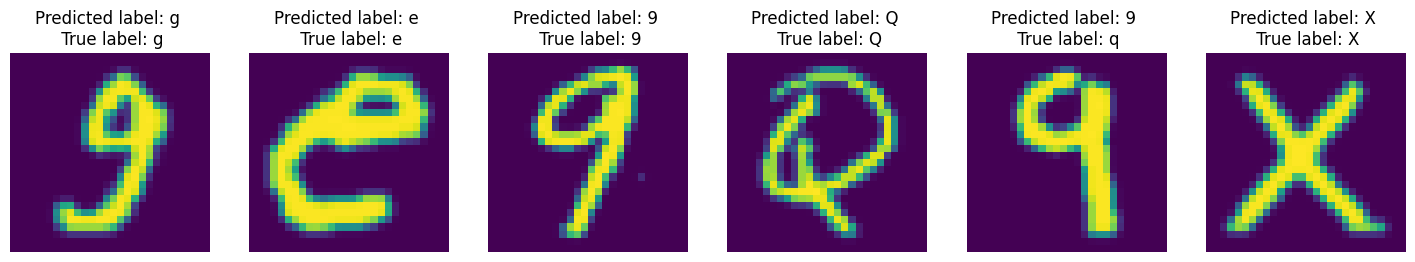

In [ ]:
# Display the previous 6 samples from the test dataset along with their predicted labels for the MLP model
display_images_with_predictions(x_test[:6], title='', y_true_labels=y_test[:6], model=best_model)

## 6.2. Confusion Matrix

### 6.2.1. Confusion Matrix(CNN)

588/588 [==============================] - 5s 8ms/step


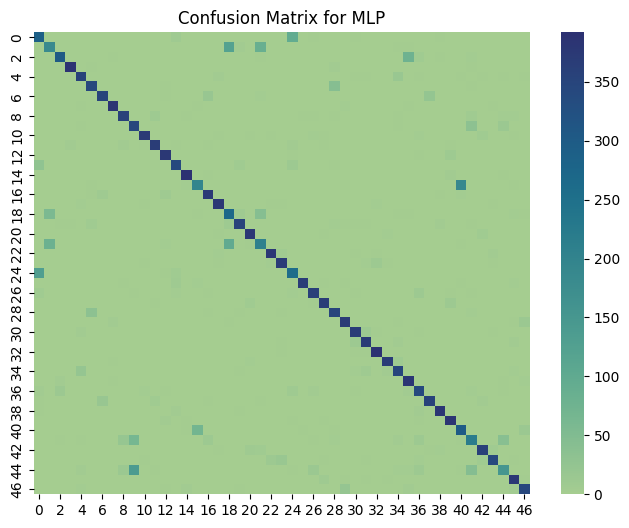

In [ ]:
# Make predictions on the test dataset
predicted_probabilities = model_cnn.predict(x_test)

# Extract the class with the highest probability for each sample
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Convert one-hot encoded true labels to integers
# because the confusion_matrix() function expects integer labels rather than
# one-hot encoded labels for computing the confusion matrix
true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ax1 = plt.axes()
sns.heatmap(conf_matrix, ax=ax1, cmap="crest")
ax1.set_title("Confusion Matrix for CNN")
plt.show()

### 6.2.2. Confusion Matrix(MLP)

588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.8030 - loss: 0.6275
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.8528 - loss: 0.4378
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


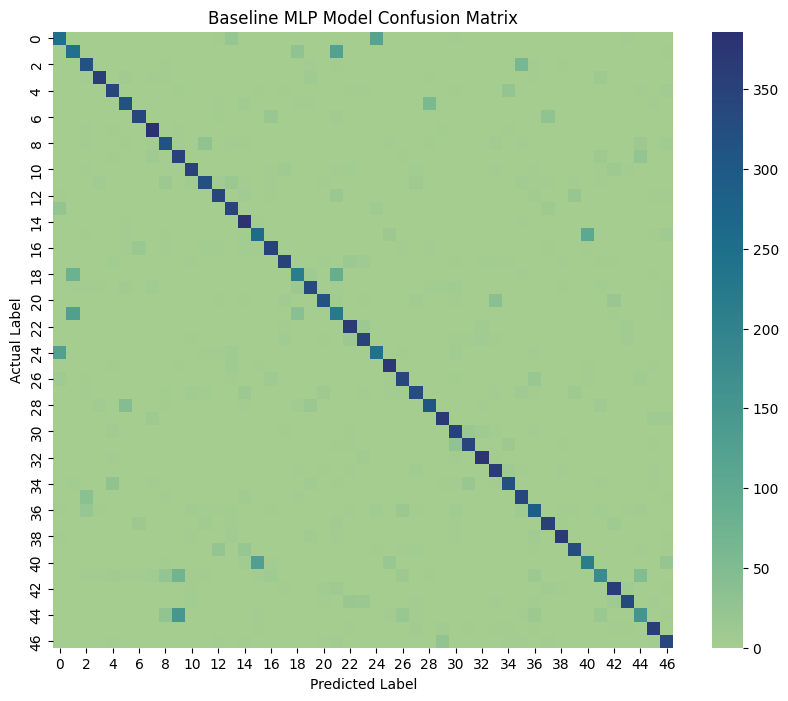

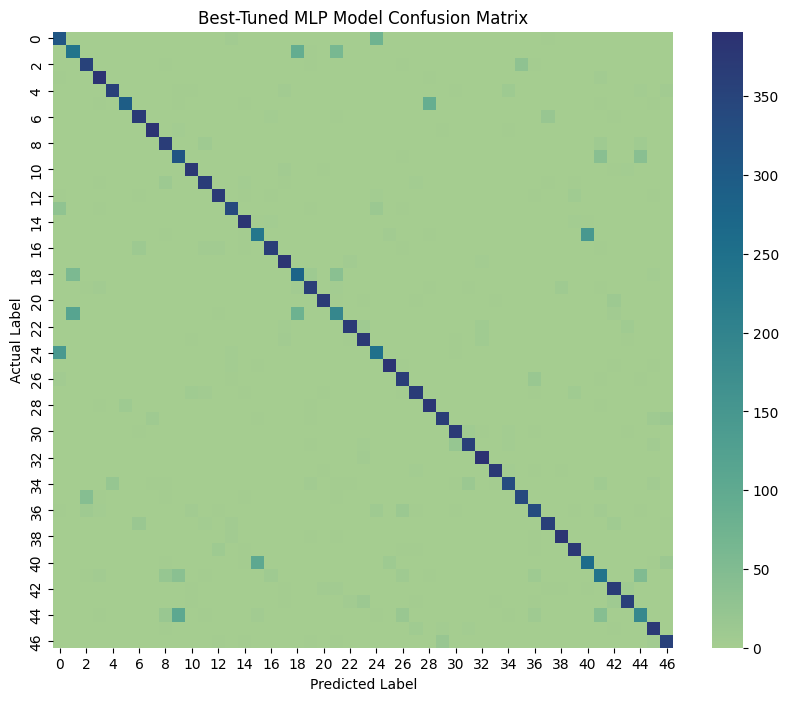

In [ ]:
# True labels from y_test
true_labels = y_test.argmax(axis=1)

# Evaluate the baseline model
baseline_loss, baseline_accuracy = baseline_mlp_model.evaluate(x_test, y_test)
baseline_predictions = baseline_mlp_model.predict(x_test)
baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(y_test.argmax(axis=1), baseline_predictions.argmax(axis=1), average='weighted')


# Evaluate the best-tuned model
best_loss, best_accuracy = best_model.evaluate(x_test, y_test)
best_predictions = best_model.predict(x_test)
best_precision, best_recall, best_f1, _ = precision_recall_fscore_support(y_test.argmax(axis=1), best_predictions.argmax(axis=1), average='weighted')

# Generate confusion matrices for both models to visualize the accuracy of each
baseline_cm = confusion_matrix(y_test.argmax(axis=1), baseline_predictions.argmax(axis=1))
best_cm = confusion_matrix(y_test.argmax(axis=1), best_predictions.argmax(axis=1))

def plot_confusion_matrix(cm, title):
    """
    Plots a confusion matrix using seaborn's heatmap functionality to provide a visual representation of model accuracy.

    Parameters:
    - cm (array): Confusion matrix array.
    - title (str): Title for the confusion matrix plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, fmt="d", cmap='crest')
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix for the baseline model
plot_confusion_matrix(baseline_cm, 'Baseline MLP Model Confusion Matrix')

# Plot confusion matrix for the best-tuned model
plot_confusion_matrix(best_cm, 'Best-Tuned MLP Model Confusion Matrix')


## 6.3 Model performance

### 6.3.1. Optimized CNN model performance

In [ ]:
# Get the index of the class with the highest probability for each sample
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Convert one-hot encoded true labels to integers
true_labels = np.argmax(y_test, axis=1)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the evaluation metrics
print('Precision score:', precision)
print('Recall score:', recall)
print('F1 score:', f1)
print('Accuracy score:', accuracy)

588/588 [==============================] - 5s 9ms/step
Precision score: 0.8470943461184247
Recall score: 0.845531914893617
F1 score: 0.8433691299436518
Accuracy score: 0.845531914893617


### 6.3.2. Optimized MLP model performance

In [ ]:
# Prepare data for comparison of model performance
data = {
    "Metric": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score"],
    "Baseline Model": [baseline_loss, baseline_accuracy, baseline_precision, baseline_recall, baseline_f1],
    "Best-Tuned Model": [best_loss, best_accuracy, best_precision, best_recall, best_f1]
}

# Create a DataFrame from the comparison data dictionary
comparison_df = pd.DataFrame(data)
print(comparison_df)

      Metric  Baseline Model  Best-Tuned Model
0       Loss        0.630122          0.437666
1   Accuracy        0.801436          0.851277
2  Precision        0.803600          0.851851
3     Recall        0.801436          0.851277
4   F1 Score        0.799626          0.850013
